### 1) Gathering Input Graphs

In [1]:
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.5.1+cu124.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-2.5.1+cu124.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 95.4 MB/s eta 0:00:00:00:01:01
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu124.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 5.8 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.3 MB/s eta 0:00:00a 0:00:01


In [2]:
import torch
from torch_geometric.data import Data
from torch.serialization import add_safe_globals
import os

# Allow PyTorch to unpickle torch_geometric.data.Data objects
add_safe_globals([Data])

# Then load the files
graph_dir = "/kaggle/input/chicken-graph-data-edge-attr/graph_data_zip"
pt_files = [f for f in os.listdir(graph_dir) if f.endswith('.pt')]

graphs = [
    torch.load(os.path.join(graph_dir, f), weights_only=False)
    for f in pt_files
]

/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_scatter/_scatter_cuda.so: undefined symbol: _ZN2at4_ops16div__Tensor_mode4callERNS_6TensorERKS2_St8optionalIN3c1017basic_string_viewIcEEE
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/usr/local/lib/python3.11/dist-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /usr/local/lib/python3.11/dist-packages/torch_sparse/_spmm_cuda.so: undefined symbol: _ZN5torch8autograd12VariableInfoC1ERKN2at6TensorE
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [3]:
# padding so model can expect a fixed set of dimensions from graphs

max_node_dim = max(g.x.shape[1] for g in graphs)
max_edge_dim = max(g.edge_attr.shape[1] for g in graphs)

def pad_features(graph, max_node_dim, max_edge_dim):
    # Pad node features
    node_feat = graph.x
    if node_feat.shape[1] < max_node_dim:
        pad_size = max_node_dim - node_feat.shape[1]
        padding = torch.zeros((node_feat.shape[0], pad_size), dtype=node_feat.dtype)
        graph.x = torch.cat([node_feat, padding], dim=1)
    
    # Pad edge features
    edge_feat = graph.edge_attr
    if edge_feat.shape[1] < max_edge_dim:
        pad_size = max_edge_dim - edge_feat.shape[1]
        padding = torch.zeros((edge_feat.shape[0], pad_size), dtype=edge_feat.dtype)
        graph.edge_attr = torch.cat([edge_feat, padding], dim=1)
    
    return graph

In [4]:
graphs_padded = [pad_features(g, max_node_dim, max_edge_dim) for g in graphs]

### 2) GAT Global Attention Model fro XAI


=== Fold 1 ===
Epoch 1/10 - Train Loss: 4193.8516
Epoch 2/10 - Train Loss: 85.7659
Epoch 3/10 - Train Loss: 66.1174
Epoch 4/10 - Train Loss: 59.5135
Epoch 5/10 - Train Loss: 46.3581
Epoch 6/10 - Train Loss: 52.1593
Epoch 7/10 - Train Loss: 45.5384
Epoch 8/10 - Train Loss: 47.6264
Epoch 9/10 - Train Loss: 33.2190
Epoch 10/10 - Train Loss: 39.1290
Baseline RMSE: 25.1735
Permuted contact duration: RMSE = 25.2879 | Importance = 0.1144
Permuted timestamp: RMSE = 24.9551 | Importance = -0.2185
Permuted antenna ID: RMSE = 25.2607 | Importance = 0.0872

=== Fold 2 ===
Epoch 1/10 - Train Loss: 4410.7080
Epoch 2/10 - Train Loss: 57.0398
Epoch 3/10 - Train Loss: 52.1037
Epoch 4/10 - Train Loss: 40.0554
Epoch 5/10 - Train Loss: 37.2948
Epoch 6/10 - Train Loss: 25.4300
Epoch 7/10 - Train Loss: 25.3569
Epoch 8/10 - Train Loss: 30.9645
Epoch 9/10 - Train Loss: 33.1316
Epoch 10/10 - Train Loss: 23.3909
Baseline RMSE: 25.2579
Permuted contact duration: RMSE = 24.9274 | Importance = -0.3305
Permuted ti

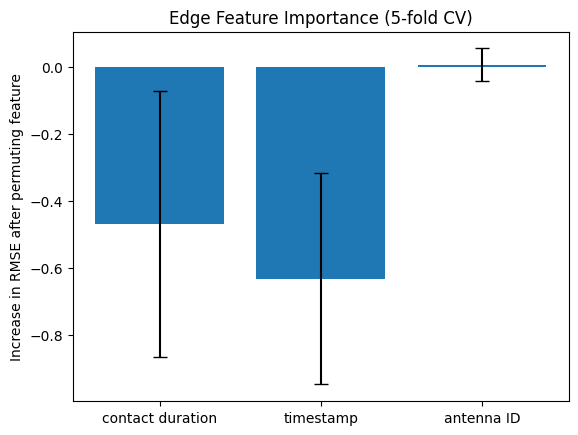

In [5]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
from torch_geometric.nn import AttentionalAggregation
from torch_geometric.loader import DataLoader
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class GATGraphRegressor(torch.nn.Module):
    def __init__(self, in_node_feats, in_edge_feats, hidden_dim=64, heads=4):
        super(GATGraphRegressor, self).__init__()
        self.gat1 = GATv2Conv(in_node_feats, hidden_dim, heads=heads, concat=True, dropout=0.2, edge_dim=in_edge_feats)
        self.gat2 = GATv2Conv(hidden_dim * heads, hidden_dim, heads=1, concat=True, dropout=0.2, edge_dim=in_edge_feats)
        self.att_pool = AttentionalAggregation(gate_nn=torch.nn.Sequential(torch.nn.Linear(hidden_dim, 1)))
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, 1)
        )

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        x = self.gat1(x, edge_index, edge_attr)
        x = F.elu(x)
        x = self.gat2(x, edge_index, edge_attr)
        x = F.elu(x)
        x = self.att_pool(x, batch)
        return self.mlp(x).squeeze(1)

def train_model(train_graphs, in_node_feats, in_edge_feats, epochs=50, batch_size=1, lr=0.001):
    model = GATGraphRegressor(in_node_feats, in_edge_feats).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()

    train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True, num_workers=0)

    model.train()
    for epoch in range(epochs):
        epoch_losses = []
        for batch_idx, batch in enumerate(train_loader):
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch)
            loss = criterion(out, batch.y.view(-1))
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
        avg_loss = np.mean(epoch_losses)
        print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {avg_loss:.4f}")
    return model

def evaluate_rmse(model, graphs, batch_size=1):
    loader = DataLoader(graphs, batch_size=batch_size, shuffle=False, num_workers=0)
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)
            all_preds.extend(out.cpu().numpy())
            all_targets.extend(batch.y.view(-1).cpu().numpy())
    rmse = mean_squared_error(all_targets, all_preds, squared=False)
    return rmse

def permute_feature_and_evaluate(model, graphs, feature_idx, batch_size=1):
    loader = DataLoader(graphs, batch_size=batch_size, shuffle=False, num_workers=0)
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            edge_attr = batch.edge_attr.clone()
            permuted_feature = edge_attr[:, feature_idx][torch.randperm(edge_attr.size(0))]
            edge_attr[:, feature_idx] = permuted_feature
            batch.edge_attr = edge_attr
            out = model(batch)
            all_preds.extend(out.cpu().numpy())
            all_targets.extend(batch.y.view(-1).cpu().numpy())
    rmse = mean_squared_error(all_targets, all_preds, squared=False)
    return rmse

feature_names = ["contact duration", "timestamp", "antenna ID"]

kf = KFold(n_splits=5, shuffle=True, random_state=42)

importances = {name: [] for name in feature_names}

in_node_feats = max_node_dim
in_edge_feats = max_edge_dim

for fold, (train_idx, val_idx) in enumerate(kf.split(graphs_padded)):
    print(f"\n=== Fold {fold + 1} ===")
    train_subset = [graphs_padded[i] for i in train_idx]
    val_subset = [graphs_padded[i] for i in val_idx]

    model = train_model(train_subset, in_node_feats, in_edge_feats, epochs=10)  # you can increase epochs later

    baseline_rmse = evaluate_rmse(model, val_subset)
    print(f"Baseline RMSE: {baseline_rmse:.4f}")

    for i, fname in enumerate(feature_names):
        permuted_rmse = permute_feature_and_evaluate(model, val_subset, i)
        importance = permuted_rmse - baseline_rmse
        importances[fname].append(importance)
        print(f"Permuted {fname}: RMSE = {permuted_rmse:.4f} | Importance = {importance:.4f}")

means = [np.mean(importances[name]) for name in feature_names]
stds = [np.std(importances[name]) for name in feature_names]

plt.bar(feature_names, means, yerr=stds, capsize=5)
plt.ylabel("Increase in RMSE after permuting feature")
plt.title("Edge Feature Importance (5-fold CV)")
plt.show()


### 3) Edge Feature Importance from Permutation (Graph Results)

- **Contact duration:** Decrease in RMSE ≈ 0.45
- **Timestamp:** Decrease in RMSE ≈ 0.60
- **Antenna ID:** Slight increase in RMSE ≈ 0.01

---

#### What does this mean?

Permuting (shuffling) each edge feature randomly tests how important that feature is to the model. Both contact duration and timestamp lead to a lower RMSE when shuffled, which suggests the model may actually perform better when these features are randomized, therefore indicating they may introduce noise rather than helpful signal. Antenna ID causes a slight increase in RMSE when shuffled, meaning it may contain a minor useful signal, though its impact remains minimal.

---

#### Main takeaway:

The model barely depends on the edge attributes to make predictions. In fact, some edge features may reduce performance. It mostly uses the graph’s node features and connectivity structure, not the detailed edge information.
